# Assignment 3

**Assignment 3: Evolutionary Algorithms**

**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

In this assignment, we are going to learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [12]:
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

EPS = 1.0e-7

In [13]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us
# an evaluation of given parameter values.
class Repressilator(object):
    def __init__(self, y_real, params):
        super().__init__()
        self.y_real = y_real.copy()
        self.params = params.copy()

    # The definition of the gene repressilator model as a system of ODEs.
    def repressilator_model(self, t, y):
        m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

        alpha0 = self.params["alpha0"]
        n = self.params["n"]
        beta = self.params["beta"]
        alpha = self.params["alpha"]

        dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
        dp1_dt = -beta * (p1 - m1)
        dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
        dp2_dt = -beta * (p2 - m2)
        dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0
        dp3_dt = -beta * (p3 - m3)

        return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

    # A numerial solver for the model (here we use Runge-Kutta 4.5)
    def solve_repressilator(self):
        # we need to use lambda function if we want to pass some parameters
        solution = solve_ivp(
            lambda t, y: self.repressilator_model(t, y),
            t_span=(self.params["t0"], self.params["t1"]),
            y0=self.params["y0"],
            method="RK45",
            t_eval=self.params["t_points"],
        )
        y_points = np.asarray(solution.y)
        return self.params["t_points"], y_points

    # An auxiliary function: setting parameters.
    def set_params(self, x):
        self.params["alpha0"] = x[0]
        self.params["n"] = x[1]
        self.params["beta"] = x[2]
        self.params["alpha"] = x[3]

    # Calculating the objective function.
    # Here, we use the Euclidean distance between the real data and the synthetic data.
    @staticmethod
    def loss(y_real, y_model):
        # we assume only m's are observed!
        y_r = y_real[0:3]
        y_m = y_model[0:3]
        if y_r.shape[1] == y_m.shape[1]:
            return np.mean(np.sqrt(np.sum((y_r - y_m) ** 2, 0)))
        else:
            return np.infty

    def objective(self, x):
        if len(x.shape) > 1:
            objective_values = []
            for i in range(x.shape[0]):
                xi = x[i]
                self.set_params(xi)

                _, y_model = self.solve_repressilator()
                objective_values.append(self.loss(self.y_real, y_model))

            objective_values = np.asarray(objective_values)
        else:
            self.set_params(x)

            _, y_model = self.solve_repressilator()
            objective_values = self.loss(self.y_real, y_model)

        return objective_values

In [14]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem
# more realistic, we add a small Gaussian noise.
params = {}
params["alpha0"] = 1.1
params["n"] = 2.9
params["beta"] = 5.5
params["alpha"] = 500
params["t0"] = 0.0
params["t1"] = 60.5
params["t_points"] = np.arange(0, 60, 0.5)
params["x0"] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145]])
params["y0"] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del r  # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5.0  # add noise!

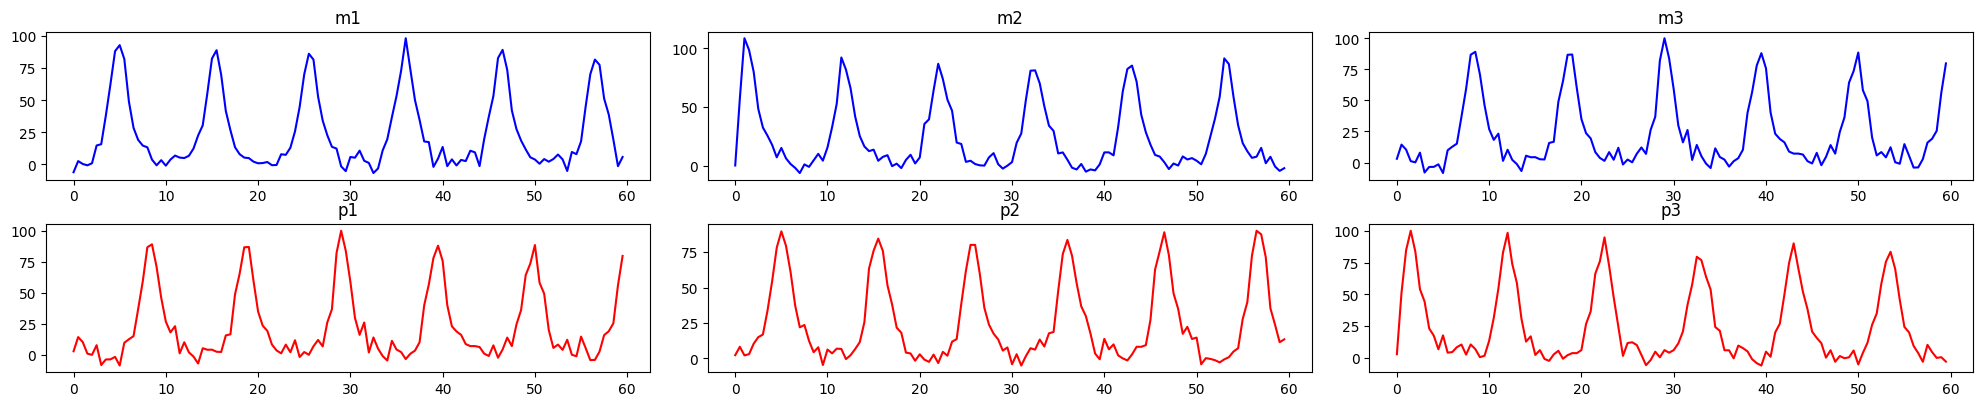

In [15]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params["t_points"]

fig_data, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
        else:
            title = "p"
            color = "r"

        axs[i, j].plot(t, y_real[2 * i + j], color)
        axs[i, j].set_title(title + str(j + 1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
Yes, I used a mutation operator. The mutation operator is implemented in the mutation method within the EA class. The choice is the Gaussian mutation, for continuous optimization problems. 

1. First loop over each individual in the population: for i in range(self.pop_size):
2. Perform mutation with probability mutation_prob: if np.random.rand() < self.mutation_prob:
3. Generate a mutation vector by sampling from a Gaussian distribution with mean 0 and standard deviation mutation_sigma. The length of the mutation vector is equal to the number of parameters in an individual: mutation_vector = np.random.normal(0, self.mutation_sigma, x_children.shape[1])
4. Add the mutation vector to the current individual: x_children[i] += mutation_vector
5. Clip the mutated individual's parameters to ensure they stay within the specified bounds: x_children[i] = np.clip(x_children[i], self.bounds_min, self.bounds_max)

I choose the Gaussian mutation because it is a simple and effective mutation operator for real-valued optimization problems. It allows for both exploration and exploitation, as the mutation can cause small or large changes in the parameter values depending on the chosen standard deviation (mutation_sigma).



**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
Yes, I used a crossover operator. The crossover operator is implemented in the recombination method within the EA class. The choice of crossover operator in this code is uniform crossover.

1. Loop through the parent population in pairs: for i in range(0, self.pop_size, 2):
2. Select two parents from the population: parent1, parent2 = x_parents[i], x_parents[i + 1]
3. Perform crossover with probability crossover_prob: if np.random.rand() < self.crossover_prob:
4. Generate a binary mask of the same length as the number of parameters in an individual, with each element randomly set to 0 or 1: mask = np.random.randint(0, 2, x_parents.shape[1], dtype=bool)
5. Apply the binary mask to create two children by taking the elements from the first parent where the mask is True and from the second parent where the mask is False. Do the opposite for the second child: child1 = np.where(mask, parent1, parent2)
child2 = np.where(mask, parent2, parent1)
6. If crossover is not performed, the children are simply copies of the parents: else:
    child1, child2 = parent1, parent2
7. Add the two children to the new population: x_children[i], x_children[i + 1] = child1, child2

Uniform crossover is chosen in this implementation because it is a simple and effective crossover operator for both continuous and discrete optimization problems. It allows for a balanced exploration of the search space by combining the genetic material of two parents, creating offspring with potentially better fitness. The binary mask ensures that each parameter value in the children is taken randomly from one of the parents, promoting diversity in the population.

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:**
The selection mechanism used is a combo of tournament selection for parent selection and truncation selection for survivor selection:

Tournament selection for parent selection:
Tournament selection is implemented in the parent_selection method within the EA class. The motivation behind using tournament selection is that it provides a good balance between exploration and exploitation while maintaining diversity in the population.

Here's how tournament selection works in this code:

1. Loop through the entire population: for i in range(self.pop_size):
2. Select tournament_size random individuals from the population without replacement: tournament_indices = np.random.choice(self.pop_size, self.tournament_size, replace=False)
3. Find the index of the individual with the best (lowest) fitness value among the selected individuals: best_idx = tournament_indices[np.argmin(f_old[tournament_indices])]
4. Add the best individual to the parent population: x_parents[i] = x_old[best_idx]
f_parents[i] = f_old[best_idx]

Tournament selection method strikes a good balance between exploration (searching the entire solution space) and exploitation (focusing on good solutions). This method ensures that better individuals have a higher probability of being selected for reproduction while maintaining population diversity by selecting parents based on their relative fitness in small tournaments.

Selection of truncation for survivor selection:

The EA class's survivor_selection method implements truncation selection. The simplicity and effectiveness of truncation selection in maintaining the best individuals in the population motivates its use for survivor selection.

Here's how truncation selection works in this code:

1. Combine the parent and offspring populations: x = np.concatenate([x_old, x_children])
f = np.concatenate([f_old, f_children])
2. Determine the number of individuals to be selected based on the survivor_selection_rate: num_selected = self.pop_size
3. Select the indices of the num_selected best (lowest) fitness individuals: selected_indices = np.argpartition(f, num_selected)[:num_selected]
4. Update the population with the selected individuals: x, f = x[selected_indices], f[selected_indices]

Truncation selection is aneffective survivor selection mechanism that directly selects the best individuals from the combined parent and offspring populations. This ensures that the best solutions found so far are preserved in the population, promoting convergence towards the global optimum. 

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:**
Besides selection, crossover, and mutation operators, no other operators are explicitly used. The main components of the evolutionary algorithm (EA) used in this code are:

Parent selection: Tournament selection, as explained in a previous answer, is used for selecting parents for reproduction.
Crossover: Uniform crossover is applied to the selected parents to generate offspring.
Mutation: Gaussian mutation is applied to the offspring with a certain mutation probability and standard deviation.
Survivor selection: Truncation selection is used to choose the next generation from the combined parent and offspring populations.
These are the primary components of a typical EA, and the provided code implements a basic version of an EA without incorporating any advanced or additional operators. The choice of these operators is motivated by their simplicity and effectiveness in solving optimization problems.

That being said, depending on the problem domain and specific requirements, other advanced operators or techniques could be employed to improve the performance of the algorithm. Some examples include:

Constraint handling: Incorporate penalty functions or other constraint-handling techniques to deal with optimization problems with constraints.
Multi-objective optimization: Use Pareto-based selection and other techniques to optimize multiple objectives simultaneously.
Parallelization: Implement parallel versions of the EA to speed up the search process, allowing for larger population sizes and more generations.

However the decision to not use these additional operators in the code was made to keep the algorithm simple and easy to understand. 



**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**
Input: repressilator, pop_size, bounds_min, bounds_max, tournament_size, crossover_prob, mutation_prob, mutation_sigma, survivor_selection_rate, num_generations

1. Initialize the repressilator with y_real and params
2. Instantiate the EA object with the given hyperparameters
3. Initialize the population x with random individuals within the given bounds
4. Evaluate the fitness f of the initial population x using the repressilator's objective function

for generation = 1 to num_generations do
    5. Perform parent selection:
        a. For each individual in the population,
            i. Select a random subset of individuals of size tournament_size
            ii. Choose the individual with the best fitness from the subset as a parent
    6. Perform recombination (crossover):
        a. For each pair of parents,
            i. With crossover probability crossover_prob, perform uniform crossover to generate two offspring
            ii. Otherwise, offspring are identical to parents
    7. Perform mutation:
        a. For each offspring,
            i. With mutation probability mutation_prob, add a Gaussian noise vector to the offspring's parameters and clip to bounds
    8. Evaluate the fitness f_children of the offspring
    9. Perform survivor selection (truncation selection):
        a. Combine parents and offspring into a single population
        b. Select the best pop_size individuals based on fitness
   10. Update the population x and fitness f with the selected survivors
   11. Record the best fitness value in the current generation
end for

Output: The best solution found over all generations, and the corresponding fitness value.


In [16]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
# =========
# Implement the Evolutionary Algorithm (EA) algorithm.
# It is equivalent to implementing the step function.
# class EA(object):
#     def __init__(self, repressilator, pop_size, bounds_min=None, bounds_max=None):
#         self.repressilator = repressilator
#         self.pop_size = pop_size
#         self.bounds_min = bounds_min
#         self.bounds_max = bounds_max
#         # -------
#         # PLEASE FILL IN
#         # all necessary hyperparameters come here
#         # -------

#     # -------
#     # PLEASE FILL IN
#     # all necessary operations (e.g., mutation, selection) must come here.
#     # -------

#     def parent_selection(self, x_old, f_old):
#         # do something

#         x_parents = x_old
#         f_parents = f_old

#         return x_parents, f_parents

#     def recombination(self, x_parents, f_parents):
#         # do something

#         return x_children

#     def mutation(self, x_children):
#         # do something

#         return x_children

#     def survivor_selection(self, x_old, x_children, f_old, f_children):
#         # do something
#         x = np.concatenate([x_old, x_children])
#         f = np.concatenate([f_old, f_children])

#         #

#         return x, f

#     # Evaluation step: DO NOT REMOVE!
#     def evaluate(self, x):
#         return self.repressilator.objective(x)

#     def step(self, x_old, f_old):
#         # -------
#         # PLEASE FILL IN
#         # NOTE: This function must return x, f
#         # where x - population
#         #       f - fitness values of the population
#         # -------

#         x_parents, f_parents = self.parent_selection(x_old, f_old)

#         x_children = self.recombination(x_parents, f_parents)

#         x_children = self.mutation(x_children)

#         f_children = self.evaluate(x_children)

#         x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

#         return x, f

class EA(object):
    def __init__(self, repressilator, pop_size, bounds_min=None, bounds_max=None, tournament_size=3, crossover_prob=0.7, mutation_prob=0.2, mutation_sigma=0.5, survivor_selection_rate=0.5):
        self.repressilator = repressilator
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max

        # Hyperparameters
        self.tournament_size = tournament_size
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.mutation_sigma = mutation_sigma
        self.survivor_selection_rate = survivor_selection_rate

    def parent_selection(self, x_old, f_old):
        x_parents = np.empty_like(x_old)
        f_parents = np.empty_like(f_old)

        for i in range(self.pop_size):
            tournament_indices = np.random.choice(self.pop_size, self.tournament_size, replace=False)
            best_idx = tournament_indices[np.argmin(f_old[tournament_indices])]
            x_parents[i] = x_old[best_idx]
            f_parents[i] = f_old[best_idx]

        return x_parents, f_parents

    def recombination(self, x_parents, f_parents):
        x_children = np.empty_like(x_parents)

        for i in range(0, self.pop_size, 2):
            parent1, parent2 = x_parents[i], x_parents[i + 1]

            if np.random.rand() < self.crossover_prob:
                mask = np.random.randint(0, 2, x_parents.shape[1], dtype=bool)
                child1 = np.where(mask, parent1, parent2)
                child2 = np.where(mask, parent2, parent1)
            else:
                child1, child2 = parent1, parent2

            x_children[i], x_children[i + 1] = child1, child2

        return x_children

    def mutation(self, x_children):
        for i in range(self.pop_size):
            if np.random.rand() < self.mutation_prob:
                mutation_vector = np.random.normal(0, self.mutation_sigma, x_children.shape[1])
                x_children[i] += mutation_vector
                x_children[i] = np.clip(x_children[i], self.bounds_min, self.bounds_max)

        return x_children

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])

        num_selected = self.pop_size
        selected_indices = np.argpartition(f, num_selected)[:num_selected]
        x, f = x[selected_indices], f[selected_indices]

        return x, f

    def evaluate(self, x):
        return self.repressilator.objective(x)

    def step(self, x_old, f_old):
        self.pop_size = x_old.shape[0]
        x_parents, f_parents = self.parent_selection(x_old, f_old)

        x_children = self.recombination(x_parents, f_parents)

        x_children = self.mutation(x_children)

        f_children = self.evaluate(x_children)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f



  


**NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best valyes of the hyperparameters here.

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [17]:
# # PLEASE DO NOT REMOVE!
# num_generations = 50  # if necessary, please increase the number of generations
# pop_size = 100
# bounds_min = [-2.0, 0.0, -5.0, 0.0]
# bounds_max = [10.0, 10.0, 20.0, 2500.0]
# # -------
# # PLEASE FILL IN!
# # Your hyperparams go here.
# # PLEASE USE THE VALUES OF THE HYPERPARAMETERS FOR WHICH YOU OBTAINED THE BEST RESULTS.
# # DO NOT ITERATE OVER THEM!
# # -------

# # Initialize the repressilator
# repressilator = Repressilator(y_real, params)

# # -------
# # PLEASE FILL IN!
# # Your object goes here:
# ea = EA()
# # -------

# # Init the population
# x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
# f = ea.evaluate(x)

# # We want to gather populations and values of the best candidates to further
# # analyze the algorithm.
# populations = []
# populations.append(x)
# f_best = [f.min()]

# # Run the EA.
# for i in range(num_generations):
#     if i % int(num_generations * 0.1) == 0:
#         print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
#     x, f = ea.step(x, f)
#     populations.append(x)
#     if f.min() < f_best[-1]:
#         f_best.append(f.min())
#     else:
#         f_best.append(f_best[-1])
# print("FINISHED!")

num_generations = 50
pop_size = 100
bounds_min = [-2.0, 0.0, -5.0, 0.0]
bounds_max = [10.0, 10.0, 20.0, 2500.0]

# Hyperparameters
tournament_size = 3
crossover_prob = 0.7
mutation_prob = 0.2
mutation_sigma = 0.5
survivor_selection_rate = 0.5

# Initialize the repressilator
repressilator = Repressilator(y_real, params)

# Instantiate the EA object
ea = EA(repressilator, pop_size, bounds_min, bounds_max, tournament_size, crossover_prob, mutation_prob, mutation_sigma, survivor_selection_rate)

# Init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
print("FINISHED!")





/var/folders/1b/8pfxz1zj3873fx2q46gg6pz80000gn/T/ipykernel_3959/2419548718.py:23: RuntimeWarning: invalid value encountered in double_scalars
  dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
/var/folders/1b/8pfxz1zj3873fx2q46gg6pz80000gn/T/ipykernel_3959/2419548718.py:25: RuntimeWarning: invalid value encountered in double_scalars
  dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0
/var/folders/1b/8pfxz1zj3873fx2q46gg6pz80000gn/T/ipykernel_3959/2419548718.py:21: RuntimeWarning: invalid value encountered in double_scalars
  dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0


Generation: 0, best fitness: 45.85
Generation: 5, best fitness: 44.11
Generation: 10, best fitness: 30.44
Generation: 15, best fitness: 22.12
Generation: 20, best fitness: 13.73
Generation: 25, best fitness: 13.72
Generation: 30, best fitness: 12.89
Generation: 35, best fitness: 12.89
Generation: 40, best fitness: 12.89
Generation: 45, best fitness: 12.89
FINISHED!


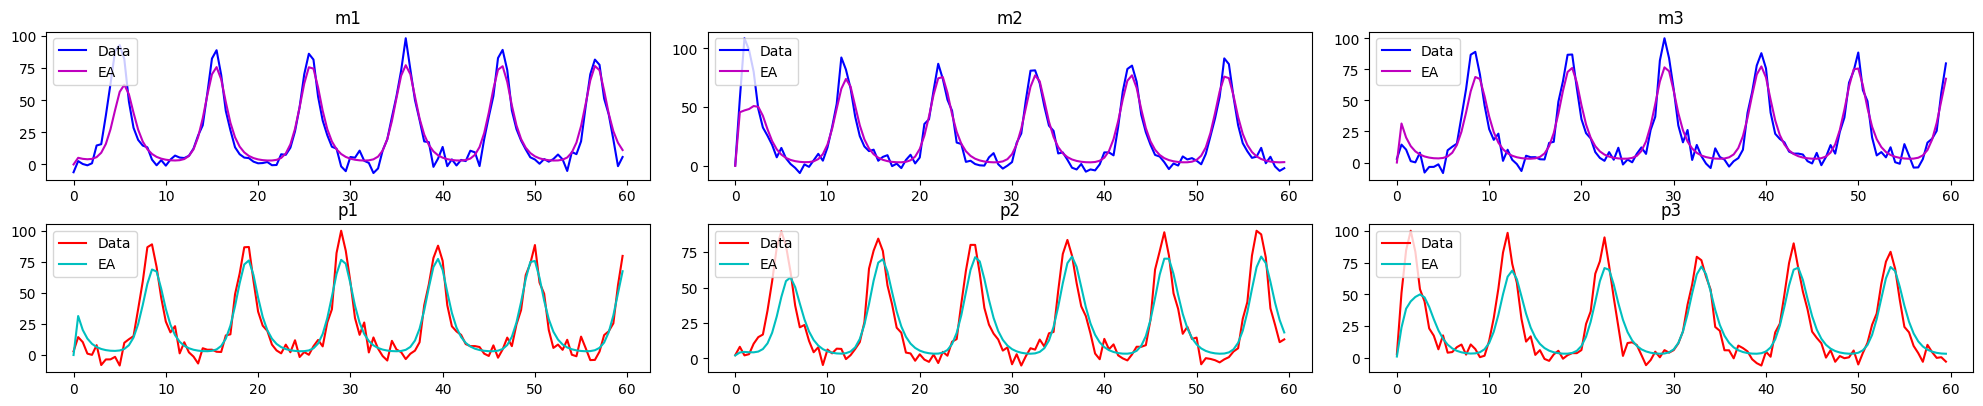

In [21]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(
    x[f.argmin()],
)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
            color_m = "m"
        else:
            title = "p"
            color = "r"
            color_m = "c"

        axs[i, j].plot(t, y_real[2 * i + j], color, label="Data")
        axs[i, j].plot(t, y_best[2 * i + j], color_m, label="EA")
        axs[i, j].set_title(title + str(j + 1))
        axs[i, j].legend()

Text(0.5, 1.0, '$n$ vs. $\\beta$')

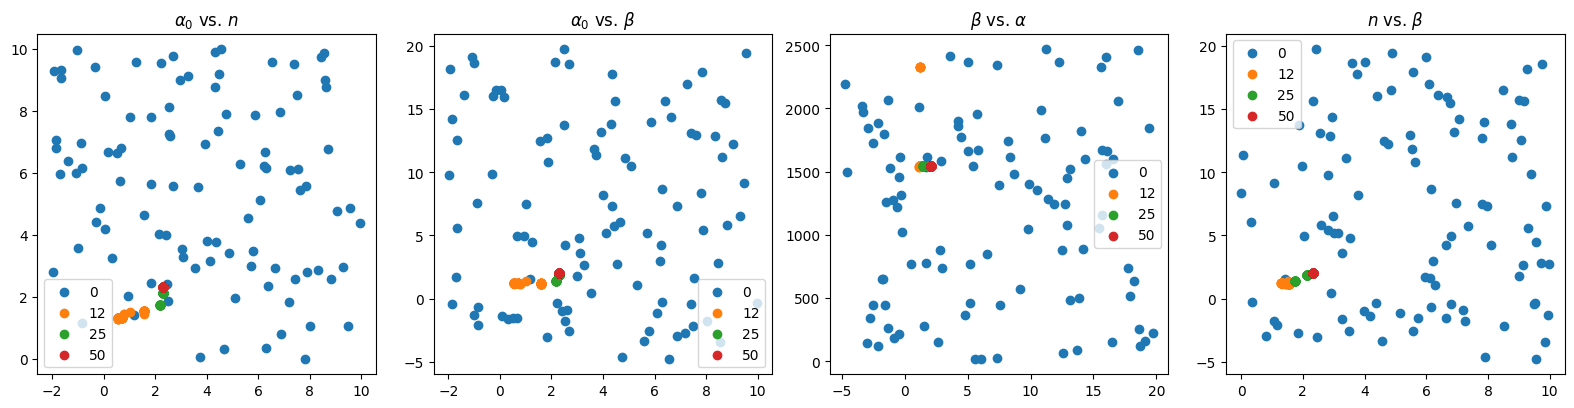

In [22]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0, num_generations // 4, num_generations // 2, num_generations]
fig_ea_pops, axs = plt.subplots(1, 4, figsize=(16, 4))
fig_ea_pops.tight_layout()


for i in range(len(gens)):
    pop_i = populations[gens[i]]
    axs[0].scatter(pop_i[:, 0], pop_i[:, 1], label=str(gens[i]))
    axs[1].scatter(pop_i[:, 0], pop_i[:, 2], label=str(gens[i]))
    axs[2].scatter(pop_i[:, 2], pop_i[:, 3], label=str(gens[i]))
    axs[3].scatter(pop_i[:, 1], pop_i[:, 2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r"$\alpha_0$ vs. $n$")
axs[1].set_title(r"$\alpha_0$ vs. $\beta$")
axs[2].set_title(r"$\beta$ vs. $\alpha$")
axs[3].set_title(r"$n$ vs. $\beta$")

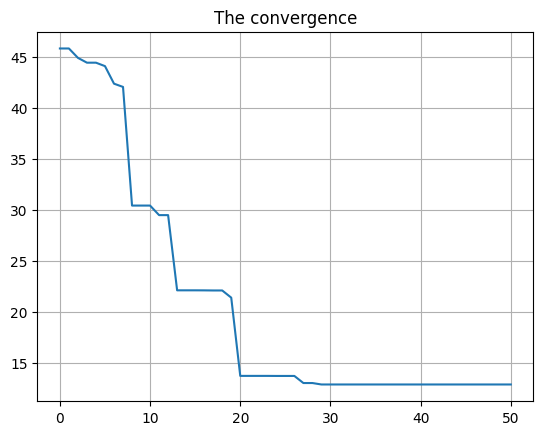

In [23]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title("The convergence")
plt.grid()

## 4. Final remarks: Analysis

Eventually, please answer the following last questions that will allow you to conclude the assignment.

**Question 6 (0-0.5pt)**: After analyzing the results, do you think your algorithm discovered the real values of the parameters? Why? Please indicate which plots indicate that? If not, what is a potential explanation?

**Answer**: When looking at all plots, we can observe that as the number of generations progresses, the fitness value consistently decreases. Nonetheless, the algorithm has not yet reached a fitness value of 0 after 50 generations. While the algorithm has successfully approached the actual parameter values, an exact match is highly unlikely. A reason for this could be because of the algotirhm getting stuck in local minima.

**Question 7 (0-0.5pt)**: How the population influences the performance of evolutionary algorithms? What population sizes did you use?

**Answer**: I used 25 and 100. With 100, more candidate solutions needed to be evaluated in each generation than with 25, which will increase the computational cost and slow down the convergence speed. I also noticed that because of the increased variation, the algorithm was able to achieve a much lower fitness value. with 10, it results in a lower running time, the evolution rate was slower, and as a result, the fitness value quickly became stuck in a local minima.

**Question 8 (0-0.5pt)**: What are the advantages of your approach?

**Answer**: By Using;

Global search: Evolutionary algorithms are known for their ability to explore a large search space and are more likely to find global optima than local optima.

AAdaptability: Because the objective function can be replaced with other functions specific to the problem at hand, the algorithm is relatively easy to adapt to different optimization problems.

No gradient information is required: Unlike gradient-based optimization techniques, the evolutionary algorithm does not require objective function gradient information. As a result, it is appropriate for problems with discontinuous or non-differentiable objective functions.

Parallelization: The nature of evolutionary algorithms allows for easy parallelization of candidate solution evaluations, which can lead to faster convergence times when using parallel computing resources.


**Question 9 (0-0.5pt)**: What are the drawbacks of your approach?

**Answer**: The evolutionary algorithm has some drawbacks that can impact its performance and applicability in certain optimization problems:
Limited exploration: Using tournament selection for parent selection and truncation selection for survivor selection can result in premature convergence, particularly if the selection pressure is too high. This may prevent the algorithm from effectively exploring the search space, potentially leading to suboptimal solutions.

Fixed hyperparameters: For mutation and crossover probabilities, as well as other hyperparameters such as mutation step size, the algorithm employs fixed values. These values may not be optimal for all problems, and an adaptive approach may produce better results.


**Question 10 (0-0.5pt)**: How could you improve convergence speed of your algorithm? Please provide very specific answer, ideally supported with literature and mathematical formulas.

**Answer**: 
The following modifications and techniques, supported by literature and specific explanations:

- Adaptive mutation and crossover rates: Improving convergence speed by adjusting mutation and crossover probabilities during the optimization process. Reduced mutation rate as the algorithm converges, for example, helps maintain population diversity while fine-tuning solutions. This idea is supported by studies such as "Adaptive Genetic Algorithms with Dynamic Population Size and Local Exploration" by Tan et al. (2001), which demonstrates the benefits of adaptive mechanisms in genetic algorithms.
- Elitism: Preserving the best individual(s) from generation to generation ensures that the algorithm does not lose the best solutions discovered thus far. Elitism can help the algorithm converge faster by applying more pressure to better solutions. This is widely discussed in the literature, such as in "An Overview of Evolutionary Algorithms for Parameter Optimization" by Back and Schwefel (1993).

Furthemore, the following lines of code can be added to the survivor_selection method to implement elitism:

def survivor_selection(self, x_old, x_children, f_old, f_children):
    x = np.concatenate([x_old, x_children])
    f = np.concatenate([f_old, f_children])

    # Elitism: Preserve the best individual
    best_idx = np.argmin(f_old)
    elite_x = x_old[best_idx]
    elite_f = f_old[best_idx]

    num_selected = self.pop_size - 1  # Reserve a slot for the elite individual
    selected_indices = np.argpartition(f, num_selected)[:num_selected]
    x, f = x[selected_indices], f[selected_indices]

    # Add the elite individual back to the population
    x[-1] = elite_x
    f[-1] = elite_f

    return x, f




**Question 11 (0-0.5pt)**: How does an EA compares with the Metropolis-Hastings algorithm? What are the similarities? What are the differences?

**Answer**: 

differences:
- EAs frequently require that the objective function be differentiable, whereas MHA does not, making it better suited to problems with non-differentiable, discontinuous, or noisy objective functions.
- An EA employs fitness to determine the gloabal optima. The MHA uses acceptance probability to accomplish the same thing.

similarities:
- To find the best solution, both algorithms converge on a global minima.
- Both EAs and MHA are stochastic optimization methods.
